# CNN preentrenada: VGG19

Utilizaremos una red neuronal convolucional preentrenada VGG19, que ha demostrado ser altamente efectiva en tareas de reconocimiento de imágenes, y la adaptaremos a nuestro propio conjunto de datos. A diferencia de entrenar una red desde cero, el uso de una red preentrenada nos permite beneficiarnos de las características aprendidas en conjuntos de datos masivos como ImageNet, lo que acelera y mejora el rendimiento de nuestra red en nuestro conjunto de datos específico.

Al adaptar la VGG19 a nuestros datos, ajustaremos las últimas capas de la red para que se adecuen a la cantidad y características de las clases que hay en nuestro conjunto. Esto nos permitirá personalizar la red para que sea capaz de reconocer y clasificar adecuadamente las clases específicas de nuestros datos.

Además, la transferencia de aprendizaje nos permite evitar el proceso lento y costoso de entrenar una red neuronal desde cero, lo que ahorra tiempo y recursos computacionales. De esta manera, podremos aprovechar el conocimiento previo de la VGG19 para obtener resultados precisos y eficientes

In [15]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import tensorflow as tf

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, optimizers, regularizers
from keras.models import load_model
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.applications.resnet50 import ResNet50
from keras import backend as K

# Cargar datos

Se va a realizar la carga, preprocesamiento y visualización de los datos con el objetivo de prepararlos para su uso en modelos de redes neuronales. A continuación, se detalla el flujo de trabajo implementado:

1. **Definición de rutas y carga de imágenes**: Se especifican las rutas de acceso a las carpetas que contienen las imágenes de entrenamiento y prueba para lesiones benignas y malignas. Las imágenes se cargan en memoria, convirtiéndolas al formato RGB para garantizar la consistencia en la representación de color.

2. **Generación de etiquetas**: Para cada imagen, se asigna una etiqueta numérica que indica si la lesión es benigna (0) o maligna (1). Este proceso se realiza tanto para el conjunto de entrenamiento como de prueba.

3. **Combinación y barajado de datos**: Los datos de imágenes y etiquetas se combinan y luego se barajan aleatoriamente. Este paso es crucial para evitar cualquier sesgo durante el entrenamiento del modelo, asegurando que la distribución de los ejemplos sea uniforme.

4. **Visualización de los datos**: Finalmente, se visualiza una selección de imágenes del conjunto de entrenamiento. Cada imagen se muestra con su respectiva etiqueta, permitiendo una verificación visual rápida de la correcta carga y etiquetado de los datos.


In [2]:
folder_benign_train = 'dataset/data/train/benign'
folder_malignant_train = 'dataset/data/train/malignant'

folder_benign_test = 'dataset/data/test/benign'
folder_malignant_test = 'dataset/data/test/malignant'

In [3]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [4]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [5]:
# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [6]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

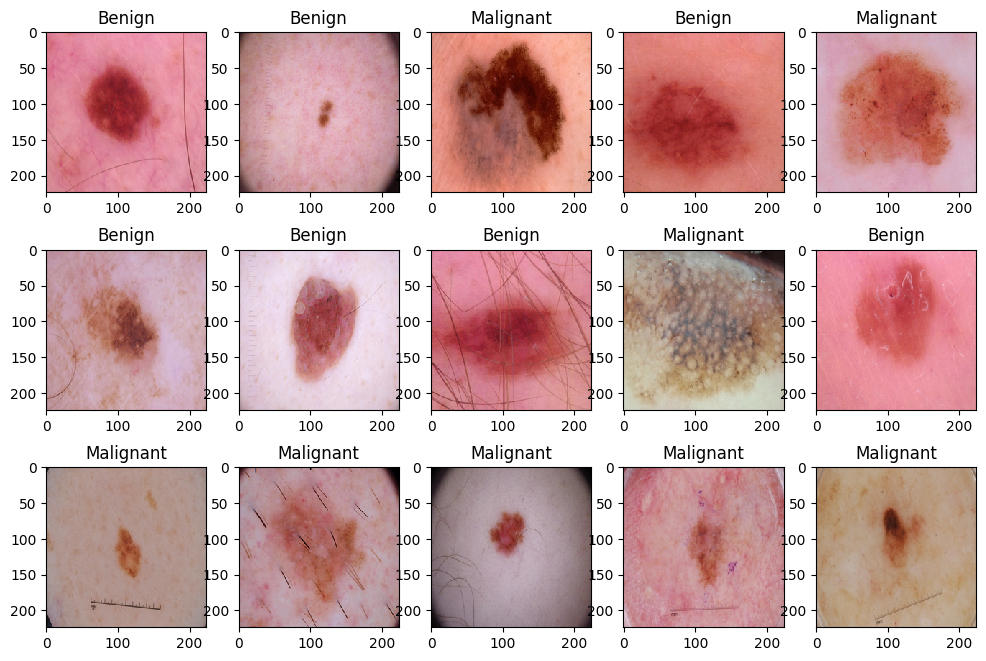

In [7]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Convertir etiquetas a categóricas

In [8]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalizar
Se realiza una normalización de los valores de píxeles de las imágenes tanto en el conjunto de entrenamiento como en el de prueba. Cada valor de píxel, originalmente en el rango de 0 a 255, se divide por 255 para obtener valores en el rango de 0 a 1. De esta manera se mejora la convergencia del modelo durante el entrenamiento, asegurando que todos los píxeles contribuyan equitativamente al aprendizaje y que los procesos computacionales se optimicen.

In [9]:
X_train = X_train/255.
X_test = X_test/255. 

# Cargar modelo preentrenado

In [10]:
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [11]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Se procede a hacer la extracción de características del modelo preentrenado para un nuestro conjuntos de datos de imágenes de entrenamiento y prueba. 

Estas características se utilizan como entrada para un modelo de red neuronal densamente conectado que consta de capas densas con activación 'relu' y 'softmax'. A pesar de tener solamente dos clases, maligno y benigno, se ha utilizado softmax porque si no el código daba error.

El modelo se compila con un optimizador RMSprop, una función de pérdida de entropía cruzada categórica para clasificación multiclase y métricas de precisión. 

Luego, el modelo se entrena durante 100 épocas con un tamaño de lote de 20 y se valida con los datos de prueba. 

In [12]:
def extract_features(samples, labels):
    features = conv_base.predict(samples)
    return features, labels

X_train_features, y_train_features = extract_features(X_train, y_train)
X_test_features, y_test_features = extract_features(X_test, y_test)

21/21 [==============================] - 8s 412ms/step


In [13]:
train_features = np.reshape(X_train_features, (X_train_features.shape[0], 7 * 7 * 512))
test_features = np.reshape(X_test_features, (X_test_features.shape[0], 7 * 7 * 512))

In [22]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Usar 2 unidades de salida con activación softmax

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

history = model.fit(train_features, y_train_features,
                    epochs=100,
                    batch_size=20,
                    validation_data=(test_features, y_test_features))

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6561 - loss: 0.6274 - val_accuracy: 0.7970 - val_loss: 0.4242
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7791 - loss: 0.4696 - val_accuracy: 0.8121 - val_loss: 0.3897
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8072 - loss: 0.4222 - val_accuracy: 0.7985 - val_loss: 0.4110
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8155 - loss: 0.4036 - val_accuracy: 0.8303 - val_loss: 0.3669
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8374 - loss: 0.3803 - val_accuracy: 0.8318 - val_loss: 0.3546
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8289 - loss: 0.3851 - val_accuracy: 0.8348 - val_loss: 0.3552
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8472 - loss: 0.3347 - val_accuracy: 0.8364 - val_loss: 0.3492
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8444 - loss: 0.3355 - 

In [23]:
# guardar modelo
if not os.path.exists('models'):
    print('No existe la carpeta')
    os.mkdir('models')

model.save('models/cnn_vgg19-100.h5')

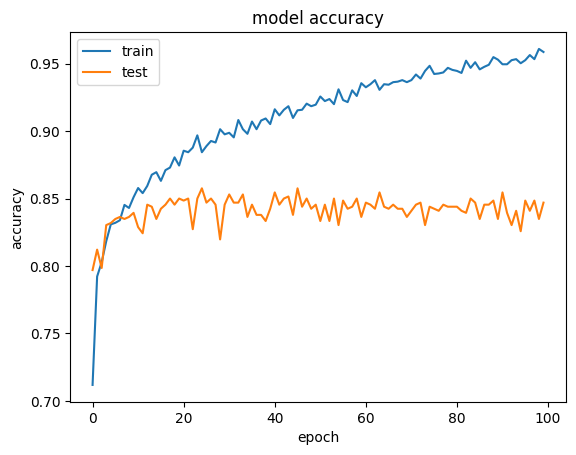

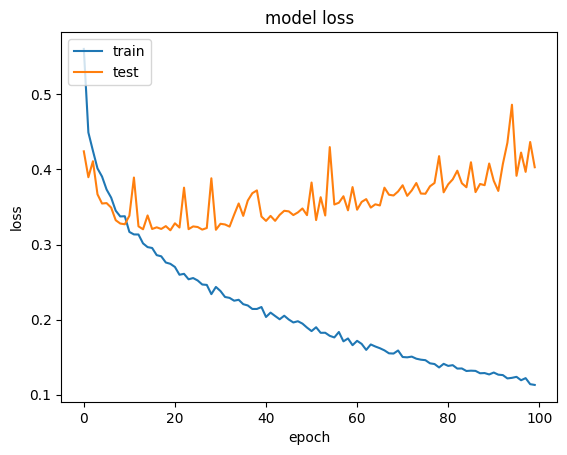

<Figure size 640x480 with 0 Axes>

In [24]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/acc-100.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/loss-100.png')

+ Gráfica accuracy: se puede observar que el conjunto de entrenamiento comienza en un nivel más bajo pero logra mejorar rápidamente hasta alcanzar un nivel más alto al final del entrenamiento, lo que indica que el modelo está aprendiendo y generalizando bien los datos de entrenamiento. Sin embargo, la precisión en el conjunto de prueba comienza en un nivel más alto pero se mantiene constante durante todas las épocas. La diferencia entre el training y el test sugiere que el modelo está sobreentrenado.

+ Gráfica loss: el conjunto de entrenamiento disminuye significativamente desde un valor inicial más alto hasta un nivel muy bajo al final del entrenamiento, lo que indica que el modelo está mejorando y ajustándose bien a los datos de entrenamiento. Por otro lado, la pérdida en el conjunto de prueba se mantiene relativamente estable alrededor del valor inicial, lo que podría indicar que el modelo está teniendo dificultades para mejorar su capacidad de generalización en los datos de prueba. Esto podría ser una señal de sobreajuste, donde el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza tan bien en datos no vistos.



Vamos a intentar usar regularización L2 para evitar el sobreentrenamiento. Esta técnina añade un término de penalización proporcional a la suma de los cuadrados de los pesos del modelo a la función de pérdida durante el entrenamiento. Este término penaliza los pesos grandes, incentivando al modelo a mantener los pesos pequeños y más uniformes, lo que contribuye a una mejor generalización en datos no vistos. Al hacer que los pesos no crezcan demasiado, la regularización L2 ayuda a asegurar que el modelo no se ajuste excesivamente a los ruidos o detalles específicos del conjunto de entrenamiento.

In [16]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

history = model.fit(train_features, y_train_features,
                    epochs=100,
                    batch_size=20,
                    validation_data=(test_features, y_test_features))

Epoch 1/100


I0000 00:00:1715536570.167063     350 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 [==============================] - 3s 6ms/step - loss: 5.1206 - accuracy: 0.7201 - val_loss: 4.5222 - val_accuracy: 0.8106
Epoch 2/100
132/132 [==============================] - 1s 4ms/step - loss: 4.1493 - accuracy: 0.7979 - val_loss: 3.7316 - val_accuracy: 0.8015
Epoch 3/100
132/132 [==============================] - 1s 4ms/step - loss: 3.4133 - accuracy: 0.8115 - val_loss: 3.0731 - val_accuracy: 0.8076
Epoch 4/100
132/132 [==============================] - 1s 4ms/step - loss: 2.8455 - accuracy: 0.8203 - val_loss: 2.5694 - val_accuracy: 0.8212
Epoch 5/100
132/132 [==============================] - 1s 4ms/step - loss: 2.3941 - accuracy: 0.8237 - val_loss: 2.1834 - val_accuracy: 0.8258
Epoch 6/100
132/132 [==============================] - 1s 4ms/step - loss: 2.0372 - accuracy: 0.8366 - val_loss: 1.8723 - val_accuracy: 0.8288
Epoch 7/100
132/132 [==============================] - 1s 4ms/step - loss: 1.7713 - accuracy: 0.8385 - val_loss: 1.6980 - val_accuracy: 0.8091
Epoch 8/100

In [18]:
# guardar modelo
if not os.path.exists('models'):
    print('No existe la carpeta')
    os.mkdir('models')

model.save('models/cnn_vgg19-100L2.h5')

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


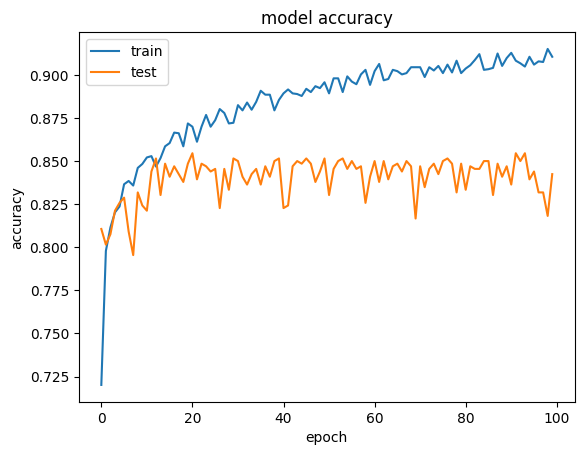

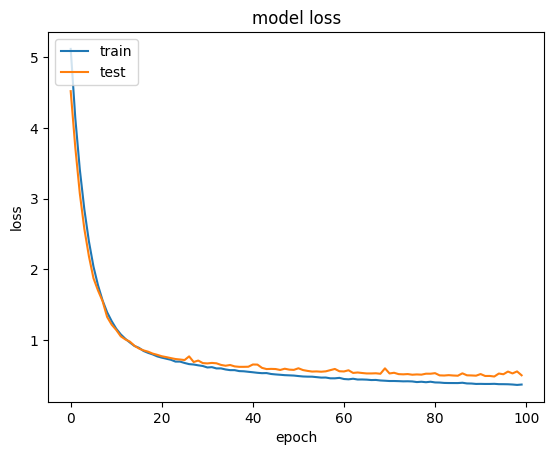

<Figure size 640x480 with 0 Axes>

In [17]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/acc-100.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/loss-100.png')

Aunque no conseguimos tanto accuracy como en el modelo anterior, en el que el training llegaba a 0.95, podemos ver que este modelo tiene menos sobreentrenamiento, ya que tanto la curva de accuracy como la de loss están más juntas, por lo que es capaz de generalizar mejor a datos que no ha visto en el entrenamiento

# Predicciones

1/1 [==============================] - 0s 135ms/step


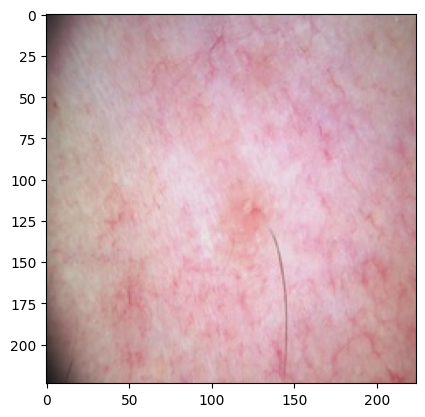

1/1 [==============================] - 0s 48ms/step
[[0.22532247 0.7746775 ]]
Maligno


In [24]:
# Cargar la base convolucional VGG19
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Cargar modelo
model = load_model('models/cnn_vgg19-100L2.h5')

# Cargar y preparar imagen
img = Image.open('dataset/data/test/malignant/110.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img / 255.0
img = img.reshape((1, 224, 224, 3))

# Extraer características usando la base convolucional
features = conv_base.predict(img)

# Redimensionar las características para que coincidan con la entrada del modelo
features = features.reshape(1, 7 * 7 * 512)

# Mostrar imagen
plt.imshow(img[0])
plt.show()

# Predecir usando el modelo
pred = model.predict(features)
print(pred)
if pred[0][0] > pred[0][1]:
    print('Benigno')
else:
    print('Maligno')

1/1 [==============================] - 0s 137ms/step


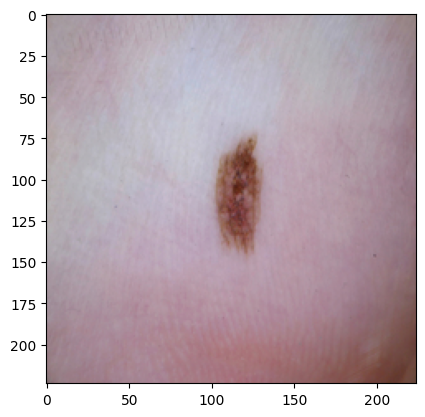

1/1 [==============================] - 0s 47ms/step
[[0.55549455 0.44450545]]
Benigno


In [23]:
# Cargar la base convolucional VGG19
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Cargar modelo
model = load_model('models/cnn_vgg19-100L2.h5')

# Cargar y preparar imagen
img = Image.open('dataset/data/test/benign/1061.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img / 255.0
img = img.reshape((1, 224, 224, 3))

# Extraer características usando la base convolucional
features = conv_base.predict(img)

# Redimensionar las características para que coincidan con la entrada del modelo
features = features.reshape(1, 7 * 7 * 512)

# Mostrar imagen
plt.imshow(img[0])
plt.show()

# Predecir usando el modelo
pred = model.predict(features)
print(pred)
if pred[0][0] > pred[0][1]:
    print('Benigno')
else:
    print('Maligno')